## Figures 3, 4, 7, 8, and 9: 
## Monte carlo oil spill volumes and oil capacity attribution

Use `analysis-rachael/env/monte_carlo.yaml` to create an environment for this notebook:
```
 conda env create -f [analysis-rachael/env/monte_carlo.yaml]
```
or, to activate this environment, use
```
 conda activate monte-carlo
```
To deactivate an active environment, use
```
 conda deactivate
```

This notebook relies on functions in `monte_carlo_utils.py` and requires the inclusion of the directory with this script, namely `../../../scripts`, in PYTHONPATH, e.g.:
```
export PYTHONPATH=$PYTHONPATH:/path/to/analysis-rachael/scripts
```
or uncommenting the following lines to import the scripts directory using sys: 
```
import sys
sys.path.insert(0, '../../../scripts')
```

The newest versions of the monte-carlo spills files can be found on Salish at the following location:
`/ocean/rmueller/MIDOSS/spill_files_091921'`

In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
from pathlib import Path
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mtick
import cartopy.crs
from cartopy import feature
import yaml

# predefined naming conventions
import MEOPAR2022_setup as oil

# graphics style
plt.style.use(r"./meopar2022_matplotlibrc.template")


## For histogram of tanker tracks

In [2]:
# importing sys
import sys
import geopandas as gpd  
# adding path to midoss_utils, from analysis-rachael/scripts
sys.path.insert(0, '../../../scripts')
from midoss_utils import concat_shp
from monte_carlo_utils import get_DOE_df, get_bin

In [3]:
spills_dir_name = 'spill_files_091921'
# On Salish
data_directory = Path(f'/ocean/rmueller/MIDOSS/{spills_dir_name}')
graphics_directory = Path('/ocean/rmueller/MIDOSS/graphics/MEOPAR_ASM_2022')
# Load Oil Attribution file 
oil_attribution_file = '/data/MIDOSS/marine_transport_data/oil_attribution.yaml'
# create list of spill files to plot/evaluate
#filenames_old = sorted(glob(os.path.join(data_directory_old,"*.csv")))
filenames = sorted(glob(os.path.join(data_directory,"*.csv")))

with open(oil_attribution_file) as file:
        oil_attrs = yaml.load(file, Loader=yaml.Loader)

# conversion factors
gal2m3 = 0.00378541
liter2m3 = 1e-3

# add suplot labels
subplot_labels=['(a)','(b)','(c)','(d)','(e)','(f)']


### Load 90,000 spills (nine 10,000 spills files)

In [4]:
df={}
for index,fn in enumerate(filenames):
    print(index,fn)
    df[index] = pd.read_csv(fn)
    # rename lagrangian files as oil types (for plotting)
    df[index]['Lagrangian_template'] = df[index]['Lagrangian_template'].replace(
         oil.fnames, oil.labels
    )
    if index == 0:
        df_combined = df[index].copy()
    else:
        df_combined = pd.concat([df_combined, df[index]])

0 /ocean/rmueller/MIDOSS/spill_files_091921/SalishSea_oil_spills_1.csv
1 /ocean/rmueller/MIDOSS/spill_files_091921/SalishSea_oil_spills_2.csv
2 /ocean/rmueller/MIDOSS/spill_files_091921/SalishSea_oil_spills_3.csv
3 /ocean/rmueller/MIDOSS/spill_files_091921/SalishSea_oil_spills_4.csv
4 /ocean/rmueller/MIDOSS/spill_files_091921/SalishSea_oil_spills_5.csv
5 /ocean/rmueller/MIDOSS/spill_files_091921/SalishSea_oil_spills_6.csv
6 /ocean/rmueller/MIDOSS/spill_files_091921/SalishSea_oil_spills_7.csv
7 /ocean/rmueller/MIDOSS/spill_files_091921/SalishSea_oil_spills_8.csv
8 /ocean/rmueller/MIDOSS/spill_files_091921/SalishSea_oil_spills_9.csv


In [5]:
df[3][['spill_volume','Lagrangian_template']].groupby('Lagrangian_template').sum()

,spill_volume
Lagrangian_template,
ANS,5.664997e+08
Bunker-C,1.058616e+09
Diesel,7.224731e+08
Dilbit,1.250000e+06
Gasoline,2.095766e+08
Jet Fuel,1.310031e+08
Other,1.228995e+08


In [6]:
# combine all files into one dataframe
plot_df = df[0][['spill_volume','Lagrangian_template']].groupby('Lagrangian_template').sum()
plot_df = plot_df.rename(columns={'spill_volume':0}) 
for index in range(1,len(filenames)):
    plot_df[index]=df[index][['spill_volume','Lagrangian_template']].groupby('Lagrangian_template').sum()

In [7]:
plot_df = plot_df.reindex(oil.labels)
# order the 4th column to show first
c = plot_df.columns
plot_df[[c[0], c[3]]] = plot_df[[c[3], c[0]]]
plot_df

,0,1,2,3,4,5,6,7,8
Lagrangian_template,,,,,,,,,
ANS,5.664997e+08,4.580198e+08,5.740982e+08,3.989567e+08,7.743527e+08,3.712767e+08,7.684448e+08,3.358490e+08,6.431348e+08
Bunker-C,1.058616e+09,1.062285e+09,1.108077e+09,1.041574e+09,1.042147e+09,1.010882e+09,1.134923e+09,1.167175e+09,1.097501e+09
Dilbit,1.250000e+06,2.318000e+07,9.882000e+07,4.053403e+07,8.966856e+07,4.905081e+07,7.783256e+07,5.866740e+07,1.708000e+07
Diesel,7.224731e+08,9.053378e+08,8.502411e+08,7.349026e+08,6.644434e+08,7.363371e+08,7.366750e+08,8.574557e+08,9.985479e+08
Gasoline,2.095766e+08,4.208539e+08,3.339501e+08,1.922510e+08,2.574210e+08,3.573719e+08,2.580917e+08,1.898333e+08,2.512536e+08
Jet Fuel,1.310031e+08,7.332830e+07,7.110522e+07,1.853786e+07,6.577042e+07,6.902465e+07,8.127753e+07,1.068080e+08,9.689354e+07
Other,1.228995e+08,2.787284e+08,8.048722e+07,1.450210e+08,2.115801e+08,1.168451e+08,1.591972e+08,1.520739e+08,2.121942e+08


## Plot spill volume by oil types

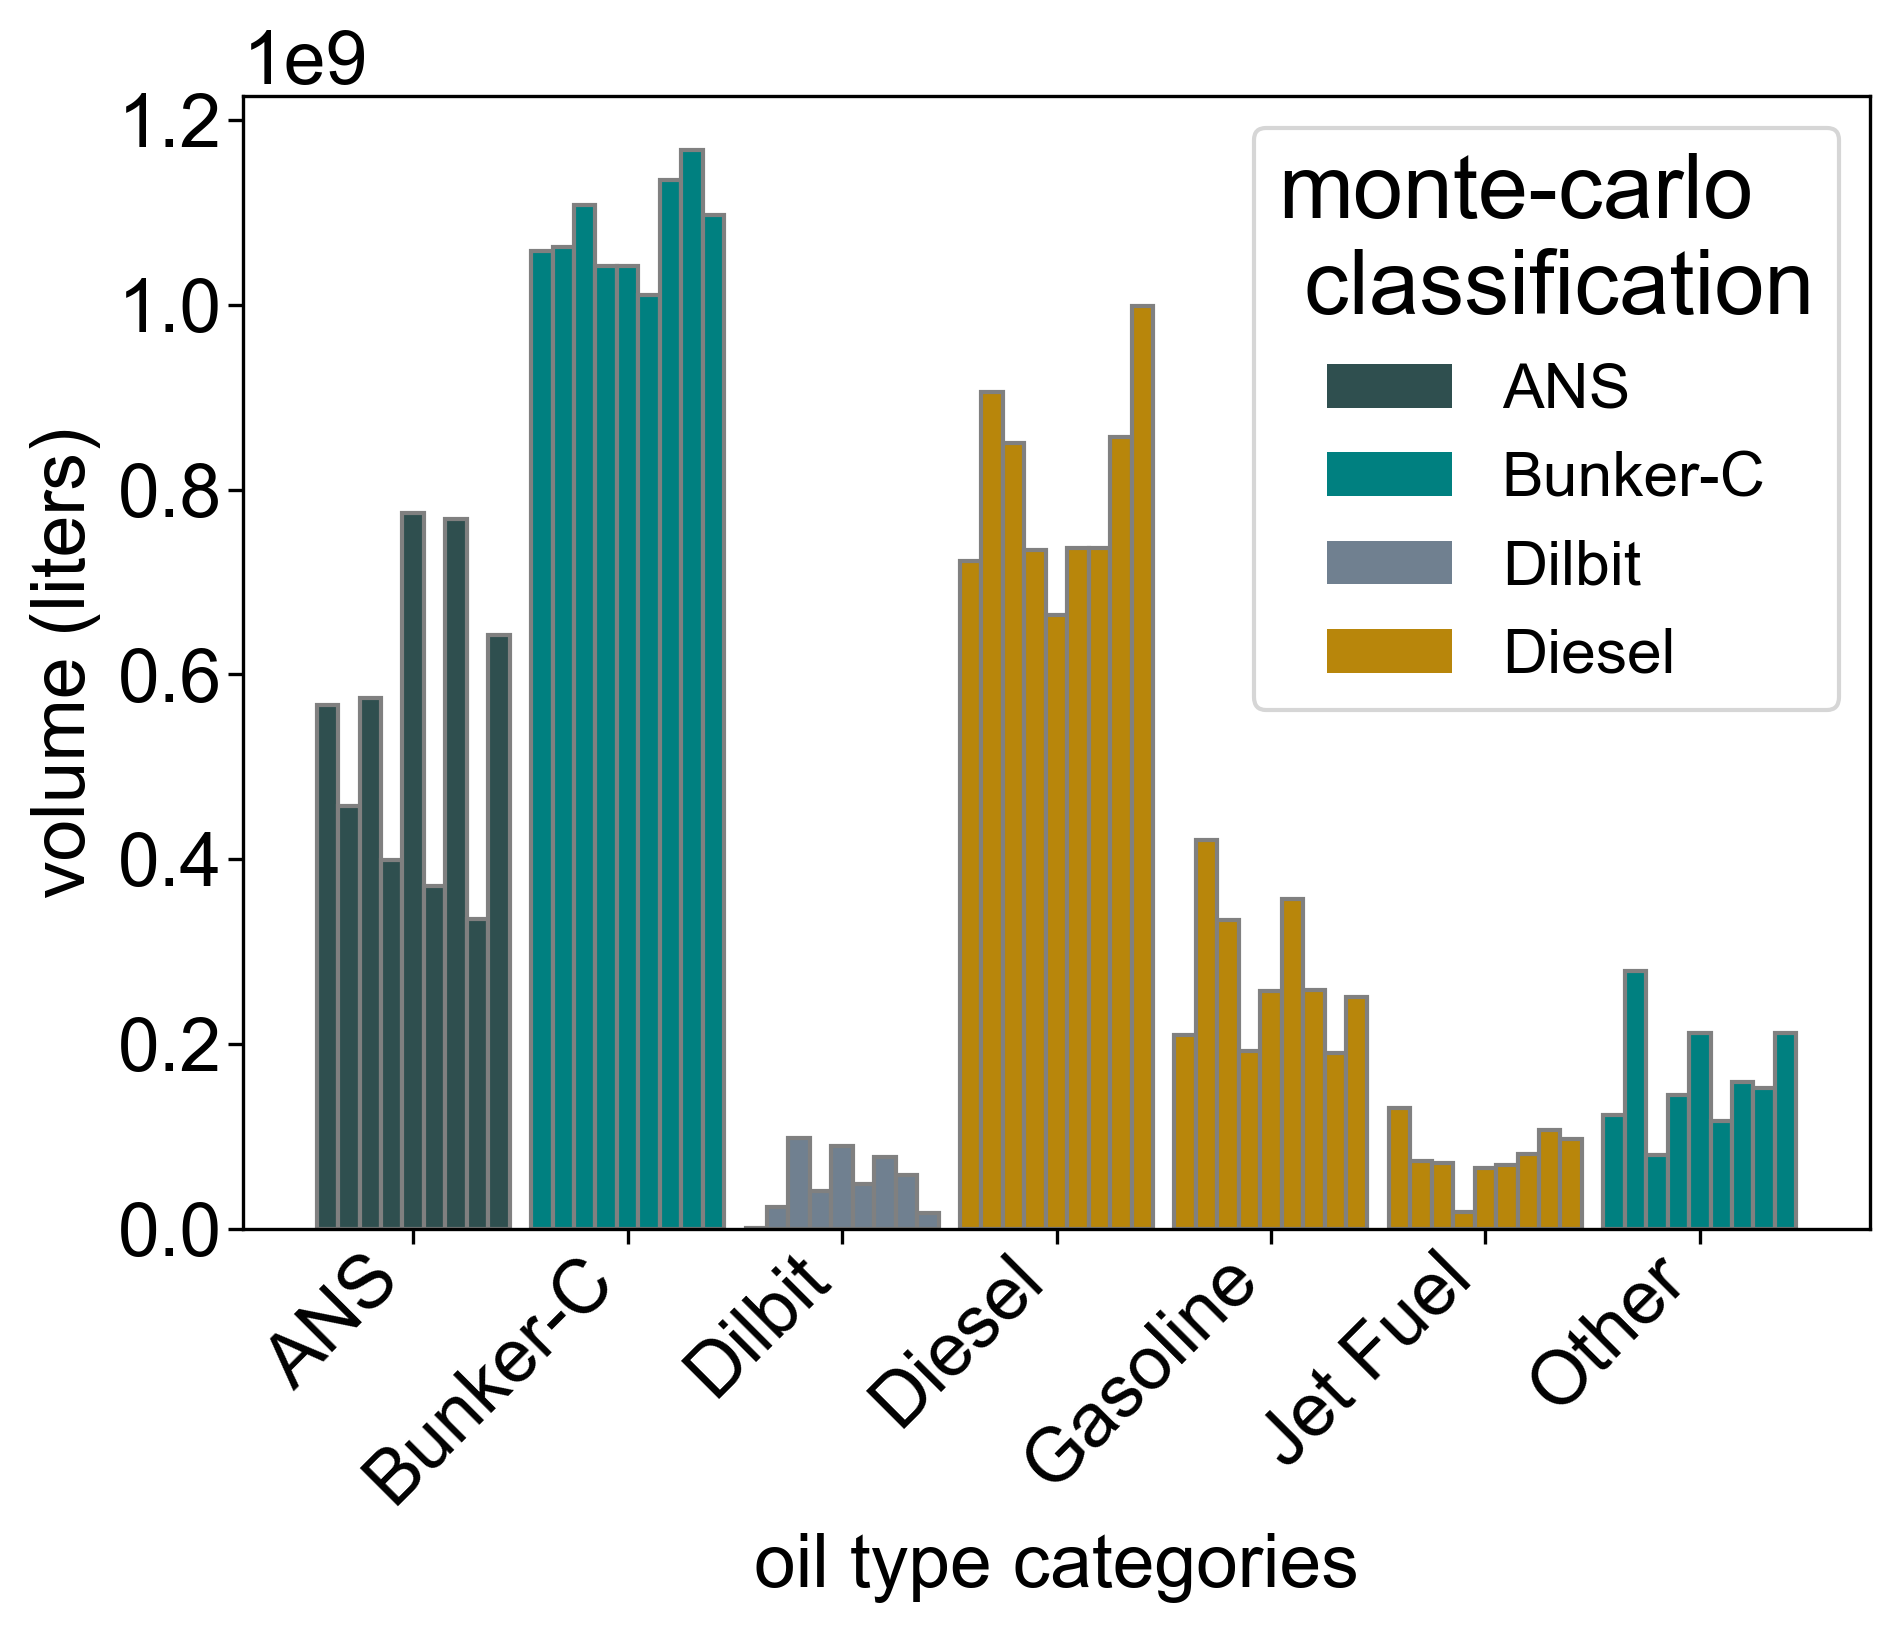

In [8]:
plt.rcParams['scatter.edgecolors']=0.8
width=0.1
ind = np.arange(len(oil.colors))
fig, ax = plt.subplots(1, 1,figsize=(7,5))
#Plot invisible bar graph but have the legends specified
for i, j in oil.MIDOSScolors.items(): #Loop over color dictionary
    ax.bar(1,plot_df[0][i],width=0,color=j,label=i) 
ax.bar(ind-4*width, plot_df[0].values, width, color=oil.colors,edgecolor='grey')
ax.bar(ind-3*width, plot_df[1].values, width, color=oil.colors,edgecolor='grey')
ax.bar(ind-2*width, plot_df[2].values, width, color=oil.colors,edgecolor='grey')
ax.bar(ind-width, plot_df[3].values, width, color=oil.colors,edgecolor='grey')
ax.bar(ind, plot_df[4].values, width, color=oil.colors,edgecolor='grey')
ax.bar(ind+width, plot_df[5].values, width, color=oil.colors,edgecolor='grey')
ax.bar(ind+2*width, plot_df[6].values, width, color=oil.colors,edgecolor='grey')
ax.bar(ind+3*width, plot_df[7].values, width, color=oil.colors,edgecolor='grey')
ax.bar(ind+4*width, plot_df[8].values, width, color=oil.colors,edgecolor='grey')
plt.ylabel('volume (liters)')
plt.xlabel('oil type categories')
plt.legend(bbox_to_anchor=(1.55, 1.0),loc=1)
ax.legend(title='monte-carlo\n classification')
ax.set_xticks([0,1,2,3,4,5,6])
ax.set_xticklabels(oil.labels, rotation=45, ha="right")
plt.savefig(graphics_directory/'Figure_9_MEOPAR_ASM_2022.png.png')

### Number of spills and spill volume by vessel type

In [9]:
vessels = [
    'atb', 'barge','tanker','cargo','cruise',
    'ferry','fishing','other','smallpass'
]


In [10]:
# create dictionary to tally spills by vessel
df={}
spill_count = {}
spill_volume = {}
spill_volume_max = {}
for vessel in vessels:
        spill_volume_max[vessel] = []
# loop through each 10,000 spill file and plot:
for file_index,file in enumerate(filenames):
    df[file_index] = pd.read_csv(file)
    spill_count[file_index] = {}
    spill_volume[file_index]={}
    # calculate and catalogue spill count
    spill_count[file_index] = df[file_index][
            ['spill_volume','vessel_type']
        ].groupby('vessel_type').count()
    spill_count[file_index] = spill_count[file_index].rename(
        columns = {'spill_volume':'spill_count'}
    )
    # calculate and catalogue spill volume
    spill_volume[file_index] = df[file_index][
            ['spill_volume','vessel_type']
        ].groupby('vessel_type').sum()
    for vessel in vessels:
        spill_volume_max[vessel].append(df[file_index][
                ['spill_volume','vessel_type']
            ].groupby('vessel_type').max()['spill_volume'][vessel])
    #ax = spill_count[file_index].spill_count[:].plot(label={'File #'file_index})
maxSpill={}
maxSpillAll = []
for vessel in vessels:
    maxSpill[vessel] = np.asarray(spill_volume_max[vessel]).max()
    maxSpillAll.append(maxSpill[vessel])
# maxSpillFraction = {}    
# maxSpillFraction{vessel: np.asarray(maxSpill[vessel])/np.asarray(maxSpillAll).max()}

In [11]:
# maxSpillFraction = {}    
# maxSpillFraction{vessel: np.asarray(maxSpill[vessel])/np.asarray(maxSpillAll).max()}

In [12]:
# maxSpillFraction

In [13]:
maxSpillFraction = pd.DataFrame(
    data=None, 
    index=spill_volume[0].index,
    columns=spill_volume[0].columns
)
maxSpillFraction=maxSpillFraction.rename(columns={"spill_volume": "max spill fraction"})
maxSpillFraction['max spill volume']=maxSpillFraction['max spill fraction']
orderedmax=[]
for vessel in vessels:
    maxSpillFraction.loc[vessel]['max spill fraction']=(
        np.asarray(maxSpill[vessel])/np.asarray(maxSpillAll).max()
    )
    orderedmax.append(maxSpill[vessel])
    maxSpillFraction.loc[vessel]['max spill volume']=maxSpill[vessel]
maxSpillFraction

,max spill fraction,max spill volume
vessel_type,,
atb,0.157842,27156756.495147
barge,0.160128,27550000.0
cargo,0.047557,8182230.431059
cruise,0.018022,3100680.265039
ferry,0.002693,463352.666097
fishing,0.00136,233962.189692
other,0.096521,16606401.761539
smallpass,0.000056,9714.431863
tanker,1.0,172050000.0


In [14]:
n=15 #>9 to avoid light greys
colors = plt.cm.cividis(np.linspace(0,1,n))

In [15]:
spill_count[0].spill_count

vessel_type
atb           154
barge        3756
cargo        1146
cruise        114
ferry        2252
fishing       492
other        1657
smallpass     290
tanker        139
Name: spill_count, dtype: int64

/tmp/ipykernel_13396/2576453678.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(spill_count[0].index.to_list(),rotation=45, ha="right")


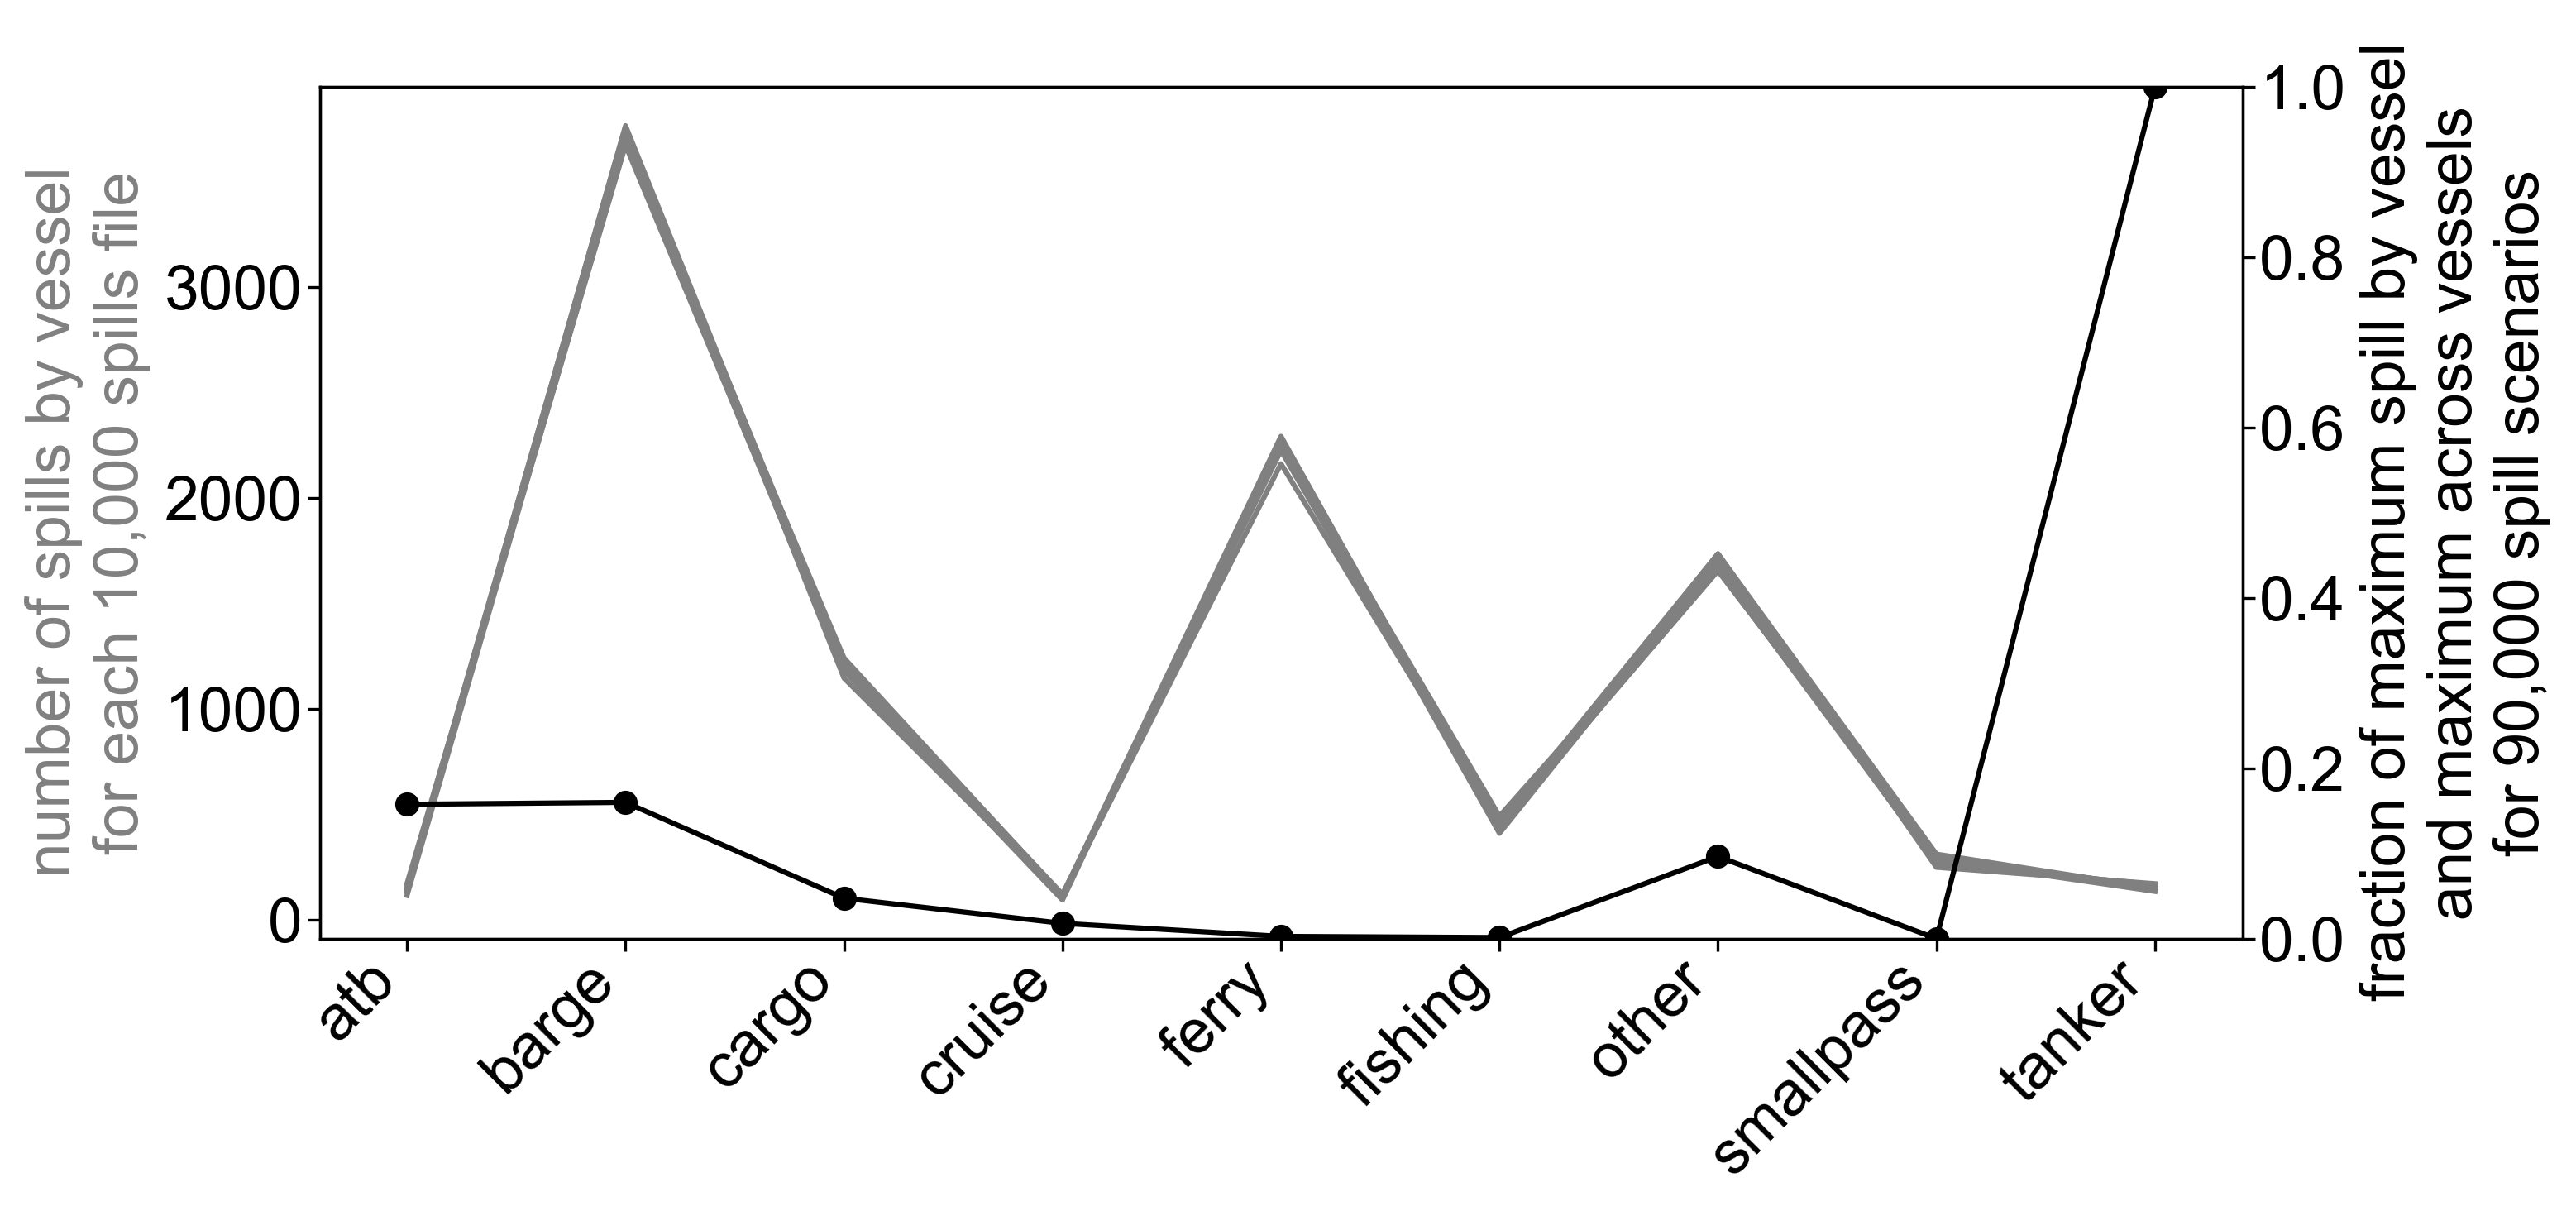

In [16]:
fig1 = plt.figure(figsize=(10, 10))
#1) spill count by vessel type
ax1 = fig1.add_subplot(211)
[ax1.plot(spill_count[ind].spill_count,'-', color='grey') for ind in np.arange(len(spill_count))]
ax1.set_xticklabels(spill_count[0].index.to_list(),rotation=45, ha="right")
#ax1.set_yticklabels(color='grey')
ax1.set_ylabel('number of spills by vessel \nfor each 10,000 spills file',color='grey')
ax2=ax1.twinx()
ax2.plot(maxSpillFraction['max spill fraction'], marker='o',color='k')
ax2.set_ylim(0,1)
ax2.set_ylabel('fraction of maximum spill by vessel \n and maximum across vessels \nfor 90,000 spill scenarios')
plt.show()
fig1.savefig(graphics_directory/'Figure_7_MEOPAR_ASM_2022.png')

/tmp/ipykernel_13396/3430992782.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(spill_volume[0].index.to_list(),rotation=45, ha="right")


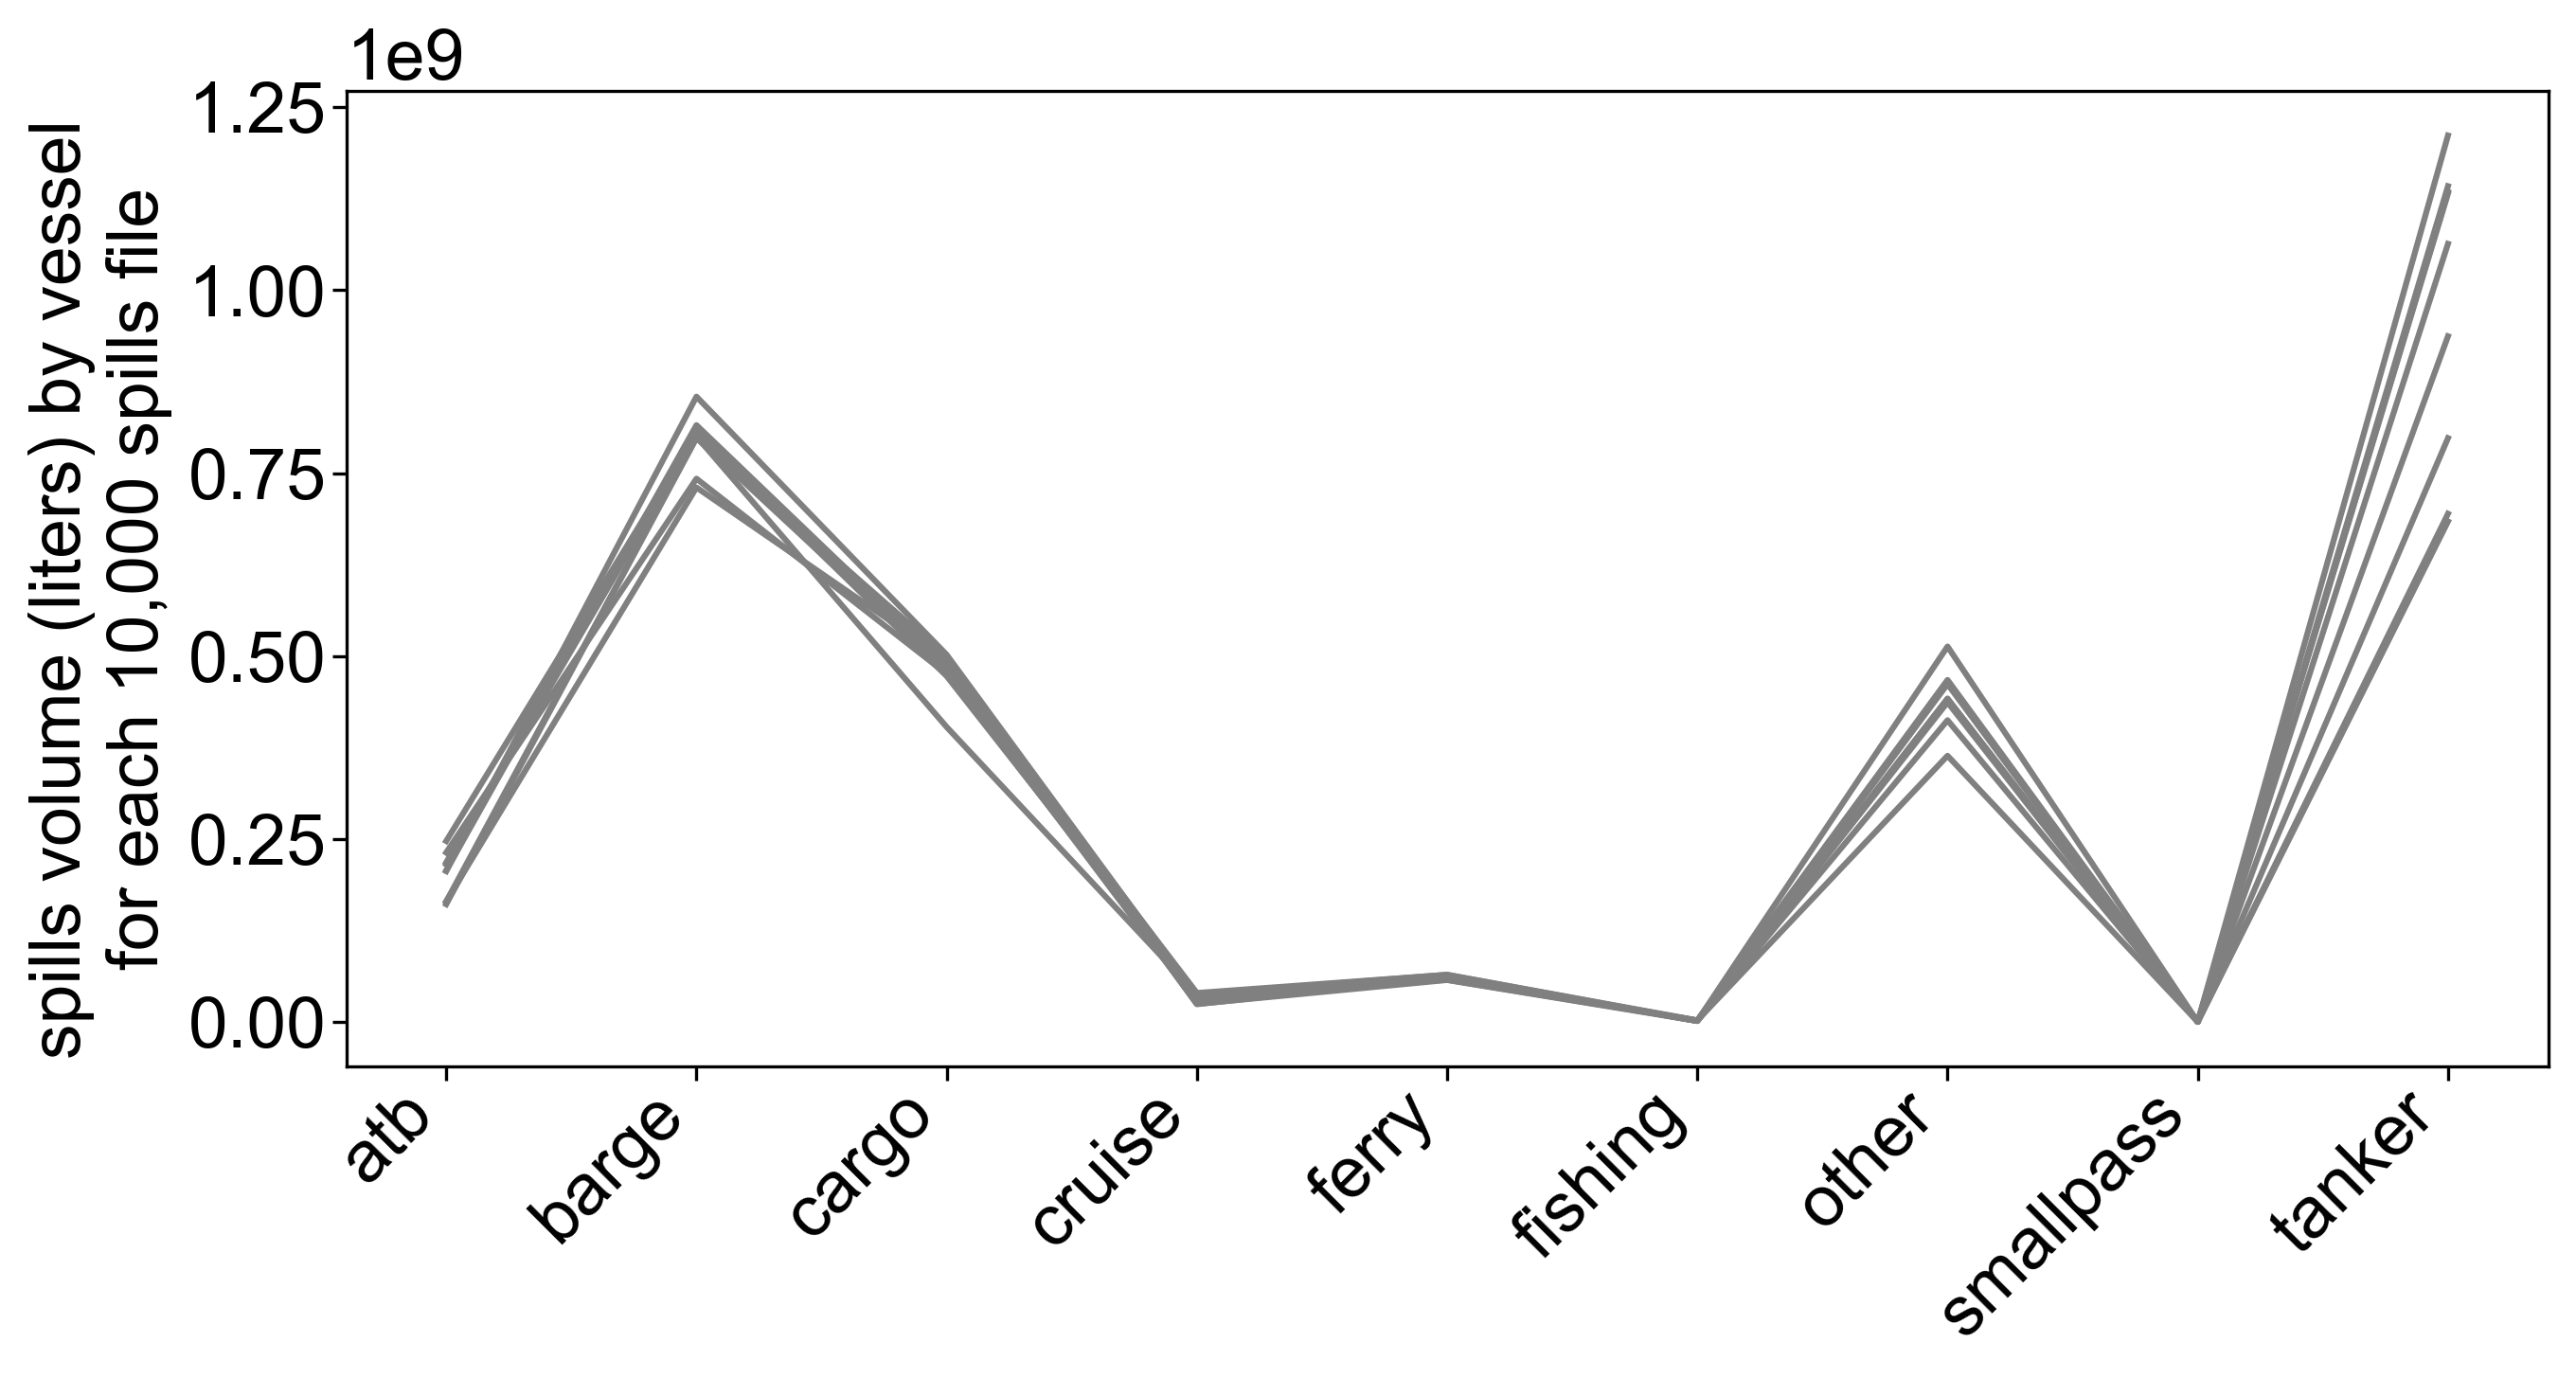

In [17]:
fig1 = plt.figure(figsize=(10, 10))
#1) spill count by vessel type
ax1 = fig1.add_subplot(211)
[ax1.plot(spill_volume[ind].spill_volume,'-', color='grey') for ind in np.arange(len(spill_count))]
ax1.set_xticklabels(spill_volume[0].index.to_list(),rotation=45, ha="right")
ax1.set_ylabel('spills volume (liters) by vessel \nfor each 10,000 spills file')
fig1.savefig(graphics_directory/'Figure_8_MEOPAR_ASM_2022.png')

## Plot oil capacities for cargo, atb, tanker
- Cargo: Line fit
- ATB: 
    - <= 50 m: Random cargo capacity by weights determined by number of AIS ship tracks
    - GT  50 m: Calculate capacity from linear fit
            C = oil_attrs["vessel_attributes"]["atb"]["cargo_fit_coefs"]
            fit_capacity = C[1] + C[0] * vessel_length
            # impose thresholds to yield output capacity
            cargo_capacity = _clamp(fit_capacity, atb_min_cargo, atb_max_cargo)
- Tanker: 
    - fuel_capacity = oil_attrs["vessel_attributes"]["tanker"][
            "fuel_capacity"
        ][bin_index]
    - cargo_capacity = oil_attrs["vessel_attributes"]["tanker"][
                "cargo_capacity"
            ][bin_index]
    - elif vessel_length > 150 and vessel_length <= 200:
            c_bin = oil_attrs["vessel_attributes"]["tanker"]["handy_capacity"]
            c_weight = oil_attrs["vessel_attributes"]["tanker"]["handy_weights"]
            cargo_capacity = random_generator.choice(
                c_bin,
                p = c_weight
            )
                
                

In [18]:
# load oil attribution file 
oilattrs_file = '/data/MIDOSS/marine_transport_data/oil_attribution.yaml'
with open(oilattrs_file, 'r') as file:
    oil_attrs = yaml.load(file, Loader=yaml.FullLoader)

In [19]:
handy_capacity = np.array(oil_attrs["vessel_attributes"]["tanker"]["handy_capacity"])
handy_weights = np.array(oil_attrs["vessel_attributes"]["tanker"]["handy_weights"])

In [20]:
#~~~ cargo traffic ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cargo_df = pd.read_excel(
    oil_attrs['files']['oil_capacity'],
    sheet_name='cargo', 
    usecols='B,D,I,J'
)
length = cargo_df['vessel length (m)']
capacity = cargo_df['fuel capacity (liters)']
vessel_type = 'cargo'
cargo_length = np.arange(150, 400, 10)
C = oil_attrs['vessel_attributes']['cargo']['fuel_fit_coefs']
cargo_fit = (
    np.exp(C[1]) * 
    np.exp(C[0]*cargo_length)
)

# add ais-curated frequency data 
good_data = length>0


### Show plot of ATB cargo bins

In [21]:
atb_capacity = np.array(oil_attrs["vessel_attributes"]["atb"]["cargo_capacity_bin_centers"])
atb_weights = np.array(oil_attrs["vessel_attributes"]["atb"]["cargo_capacity_probability"])

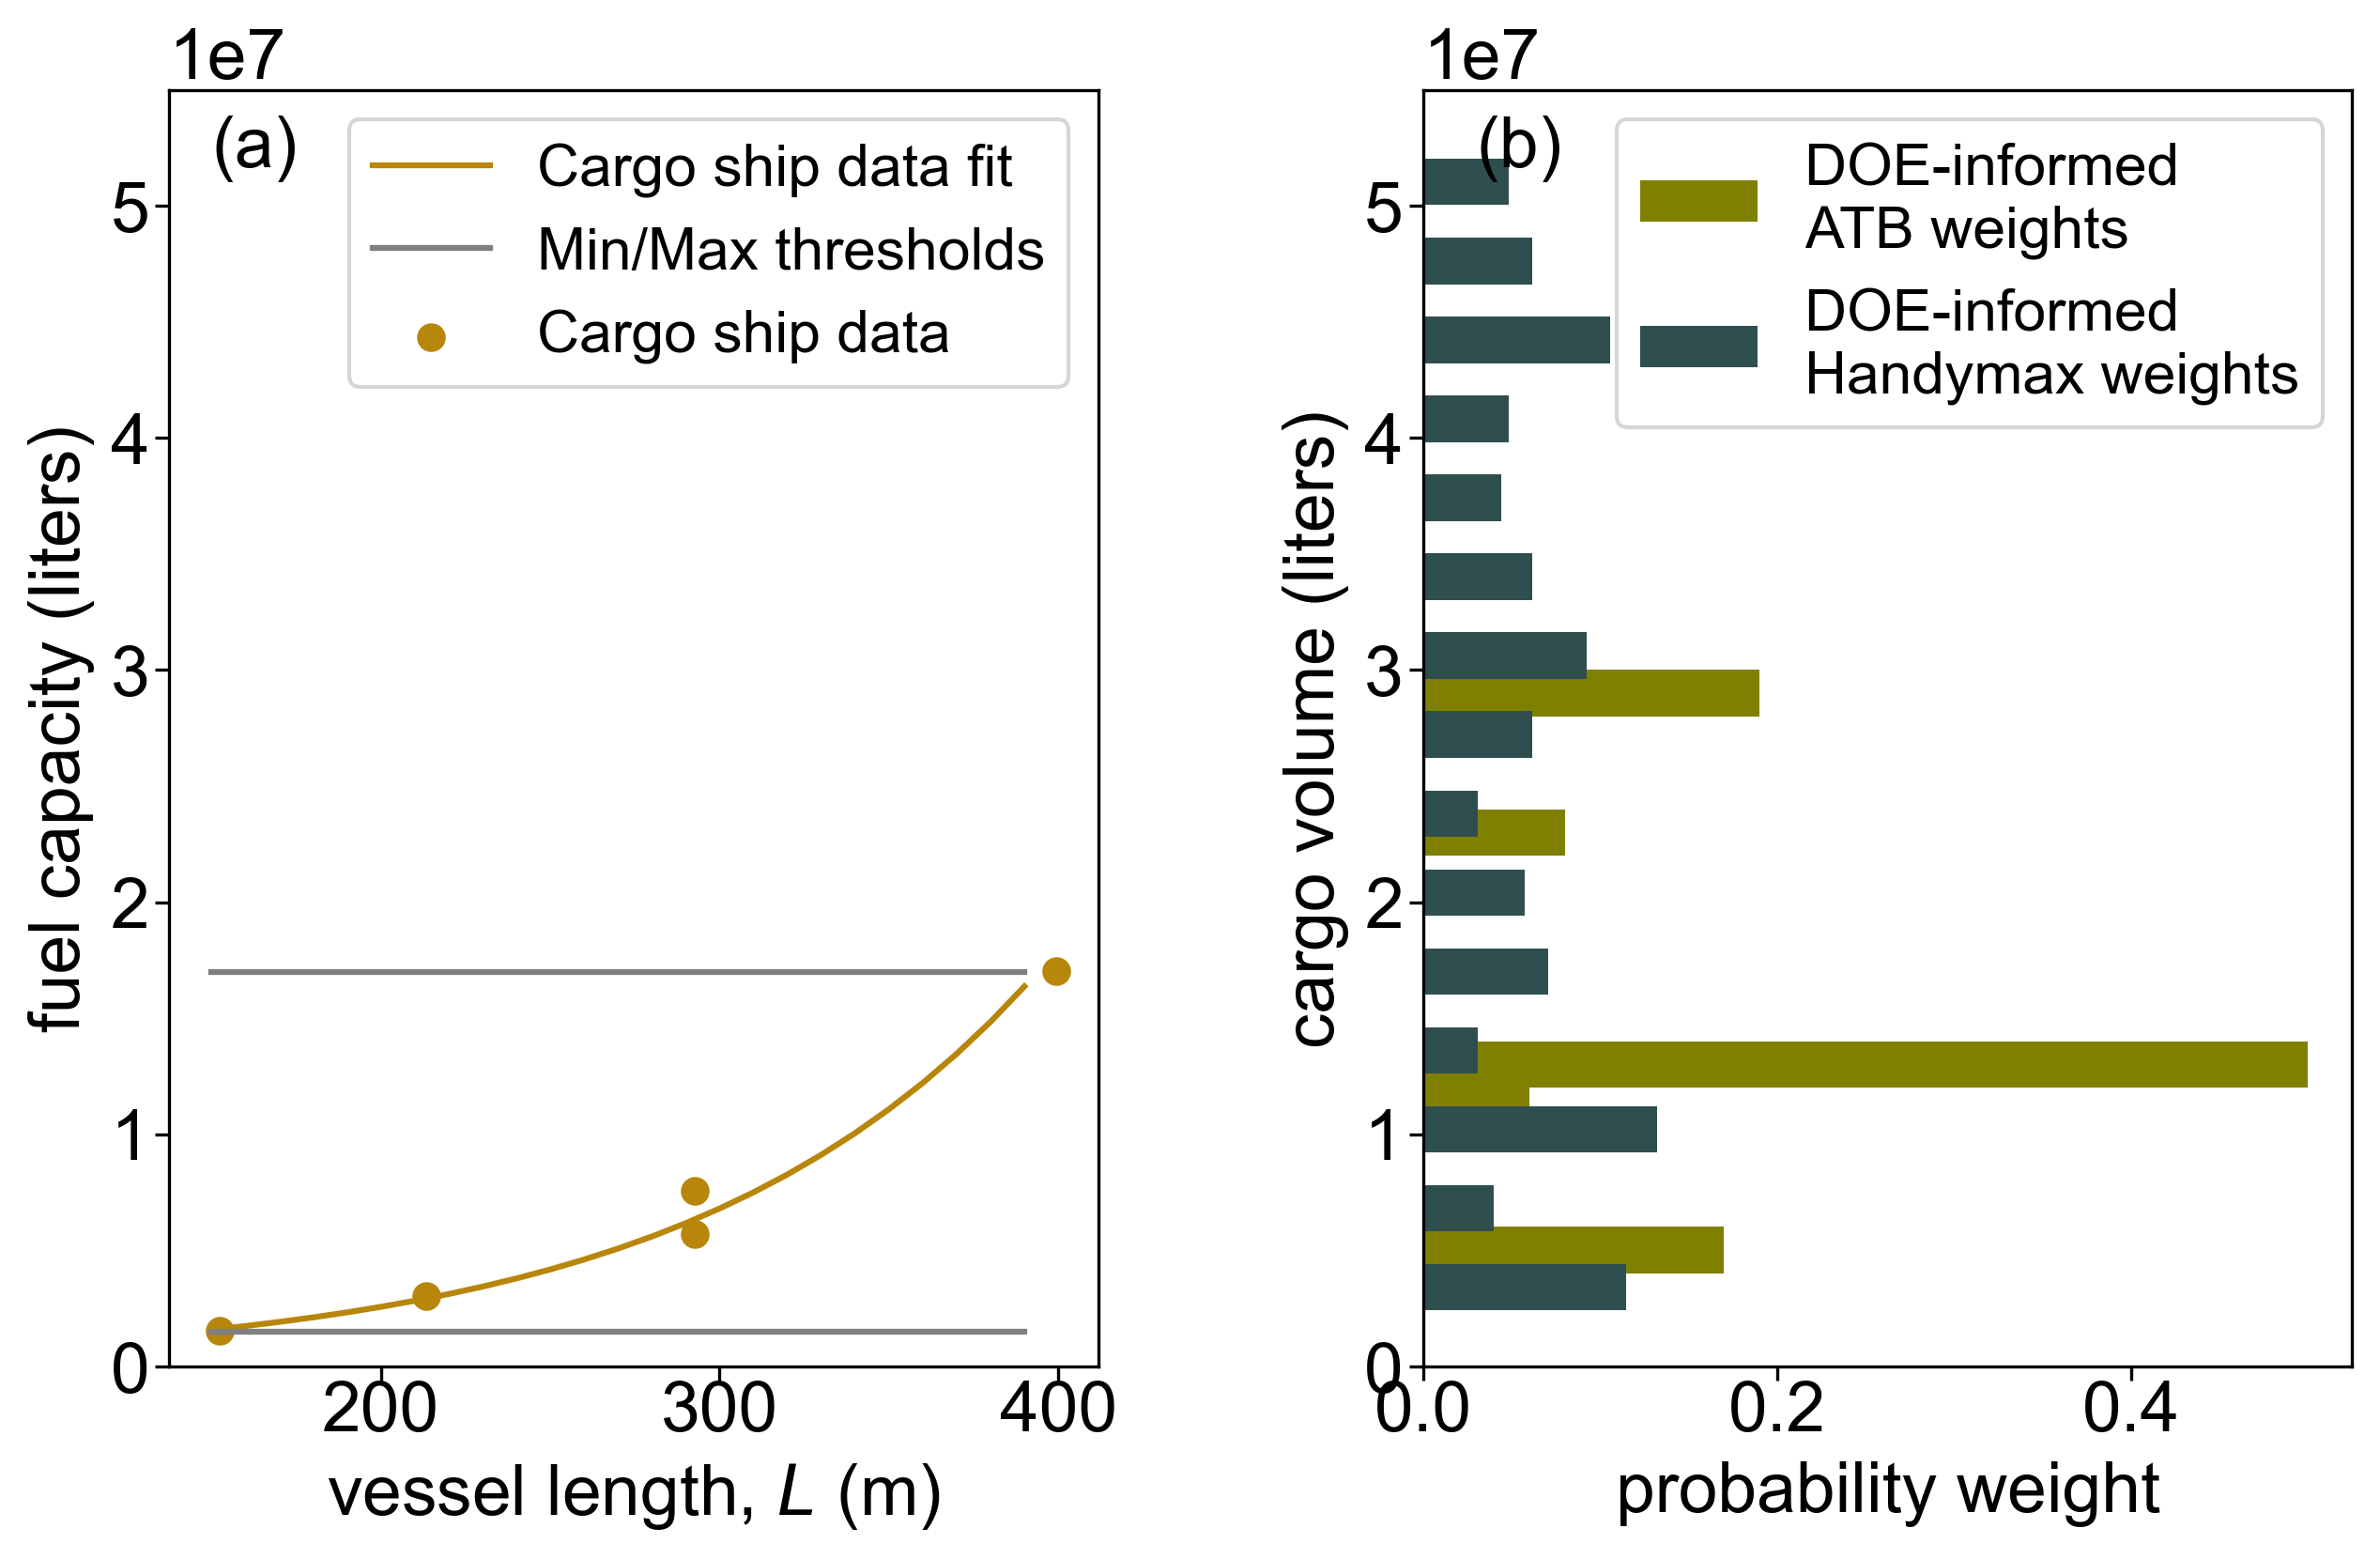

In [22]:
fig = plt.figure() 
# to change size of subplot's
# set height of each subplot as 8
fig.set_figheight(6)
# set width of each subplot as 8
fig.set_figwidth(10) 
# create grid for different subplots
spec = gridspec.GridSpec(ncols=2, nrows=1,wspace=.35,
                         hspace=1,width_ratios=[10,10])
                        #height_ratios=[4])
ax={}
ax[0] = fig.add_subplot(spec[0])
ax[1] = fig.add_subplot(spec[1])
ax[0].scatter(
    length[good_data],
    capacity[good_data],
    40,
    label='Cargo ship data ',
    color=oil.vesselcolors['cargo']
)

ax[0].plot(
    cargo_length, 
    cargo_fit, 
    c=oil.vesselcolors['cargo'], 
    label='Cargo ship data fit'#f'{np.exp(C[1]):.02e}e^{C[0]:.02f}$L$'
)

ax[0].plot(
    [np.min(cargo_length), np.max(cargo_length)],
    [oil_attrs['vessel_attributes']['cargo']['min_fuel'], 
     oil_attrs['vessel_attributes']['cargo']['min_fuel']],
    c='tab:grey',
    label='Min/Max thresholds'
)
ax[0].plot(
    [np.min(cargo_length), np.max(cargo_length)],
    [oil_attrs['vessel_attributes']['cargo']['max_fuel'], 
     oil_attrs['vessel_attributes']['cargo']['max_fuel']],
    c='tab:grey'
)
ax[0].set_ylim(0,5.5e7)
ax[0].set_xlabel('vessel length, $L$ (m)')
ax[0].set_ylabel('fuel capacity (liters)')
#ax1.set_title('Container Ship')
ax[0].legend(bbox_to_anchor=(1, 1), loc='upper right')

# TANK traffic
# ax2 = fig.add_subplot(122)
ax[1].barh(atb_capacity,atb_weights, 
         2e6,
         color=oil.vesselcolors['atb'],
         label='DOE-informed \nATB weights')
ax[1].barh(handy_capacity,handy_weights, 
         2e6,
         color=oil.vesselcolors['tanker'],
         label='DOE-informed \nHandymax weights')
ax[1].set(ylabel='cargo volume (liters)')
ax[1].set_xlabel('probability weight')
ax[1].set_ylim(0,5.5e7)
ax[1].legend(bbox_to_anchor=(1, 1), loc='upper right')

ax[0].text(150,5.5e7*0.94,subplot_labels[0])
ax[1].text(.03,5.5e7*0.94,subplot_labels[1])


plt.savefig(graphics_directory/'Figure_3_MEOPAR_ASM_2022.png')


## Create histogram of tanker lengths

In [23]:
%%time
allTracks_tanker = gpd.read_file("/home/rmueller/data/MIDOSS/Shapefiles/tanker_2018_allMonths.shp")
allTracks_tanker = allTracks_tanker.reset_index(drop=True)

CPU times: user 1min 9s, sys: 2.35 s, total: 1min 11s
Wall time: 1min 11s


In [24]:
allTracks_tanker.head()

,MMSI_NUM,ST_DATE,EN_DATE,LENGTH,TO,FROM_,geometry
0,219602000.0,2018-01-15 07:56:24,2018-01-15 07:57:24,182,US,Pacific,"LINESTRING (-128.28361 46.80076, -128.27895 46..."
1,219602000.0,2018-01-15 07:57:24,2018-01-15 07:58:58,182,US,Pacific,"LINESTRING (-128.27895 46.80302, -128.27150 46..."
2,219602000.0,2018-01-15 07:58:58,2018-01-15 07:59:27,182,US,Pacific,"LINESTRING (-128.27150 46.80663, -128.26953 46..."
3,219602000.0,2018-01-15 07:59:27,2018-01-15 07:59:46,182,US,Pacific,"LINESTRING (-128.26953 46.80759, -128.26766 46..."
4,219602000.0,2018-01-15 07:59:46,2018-01-15 08:01:24,182,US,Pacific,"LINESTRING (-128.26766 46.80852, -128.26025 46..."


In [25]:

bins = []
bins.append((0, 60))
bins.append((61, 150))
bins.append((151, 200))
bins.append((201, 250))
bins.append((251, 300))
binned_data = np.zeros(len(bins))
size_classes = [
    "Smallest Tanker (< 60 m)",
    "Small Tanker (61 - 150 m)", 
    "Handymax (151-200 m)", 
    "Aframax (201-250 m)", 
    "Suezmax (251-300 m)" 
]
binned_mmsi = pd.DataFrame(columns = size_classes)
for idx,value in enumerate(allTracks_tanker["LENGTH"]):
    if value > 0:
        bin_index = get_bin(value, bins)  
        binned_data[bin_index] += 1  

In [26]:
## From oil_attribution.ipynb
one_way=[35/37,48/48,134/(134+93),8/10,39/42]
two_way=[2/37,0/48,134/(134+93),2/10,3/42]
## From monte_carlo_QAQC/QAQC_Tanker_AISlengths_DOEcapacities.ipynb
percent_traffic = [1,.5455,.5815,.1799,.5080]

Total number of MMSI by size class (in QAQC_Tanker....)
** 1 ** Smallest Tanker (< 60 m) vessels
** 19 ** Small Tanker (61 - 150 m) vessels
** 140 ** Handymax (151-200 m) vessels
** 69 ** Aframax (201-250 m) vessels
** 29 ** Suezmax (251-300 m) vessels

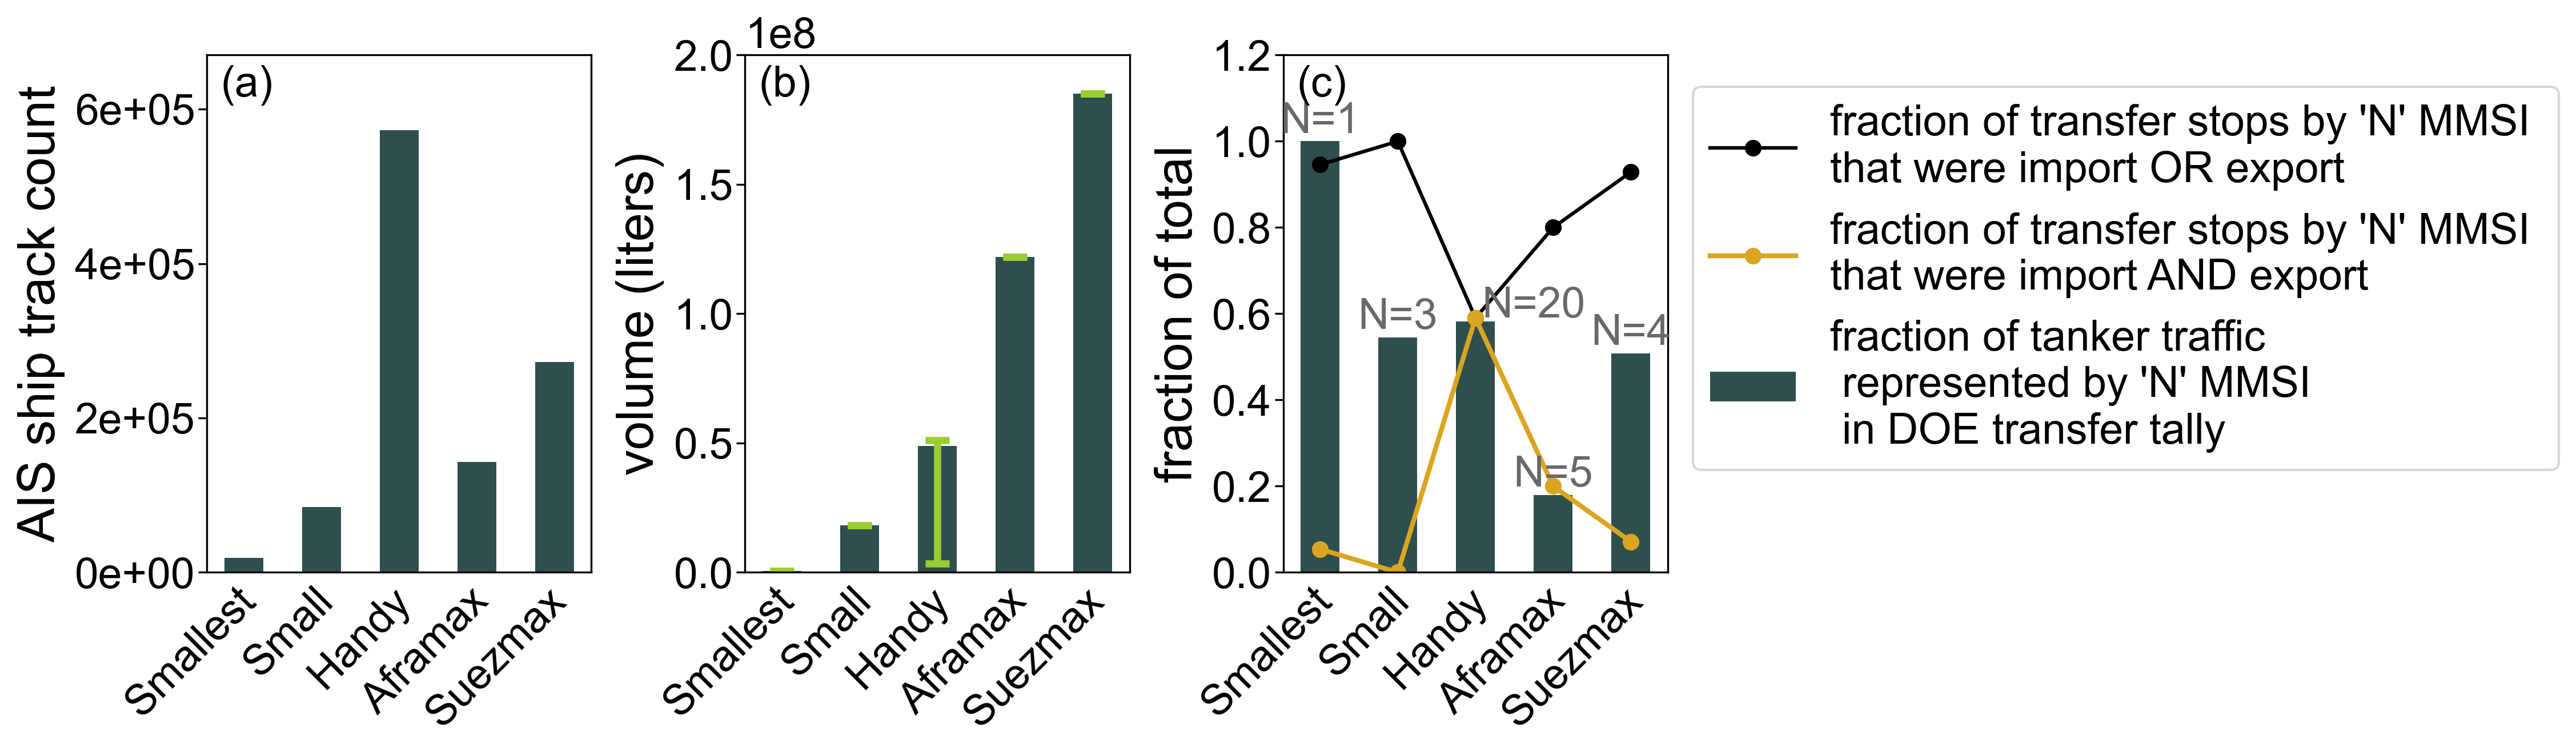

In [27]:
#plt.style.use(r"./meopar2022_matplotlibrc.template")
# min/max of oil capacity for handymax
handy_min = np.asarray(oil_attrs['vessel_attributes']['tanker']['handy_capacity']).min()
handy_max = np.asarray(oil_attrs['vessel_attributes']['tanker']['handy_capacity']).max()
size_classes_label=['Smallest','Small','Handy','Aframax','Suezmax']
fig, ax = plt.subplots(nrows=1, ncols=3, 
                       #figsize=(15, 5),
                       gridspec_kw={
                           'width_ratios': [15, 15,15],
                           'height_ratios': [1],
                       'wspace': 0.4,
                       'hspace': 0.6})   
fig.set_figheight(4)
# set width of each subplot as 8
fig.set_figwidth(11)

#width = 0.75 # the width of the bars 
ind = np.arange(len(binned_data))  # the x locations for the groups
ax[0].bar(ind, binned_data, 0.5, color=oil.vesselcolors["tanker"])
ax[0].set_xticks(ind+1/4)
ax[0].set_xticklabels(size_classes_label, minor=False, rotation=45, ha='right')
ax[0].set_ylim(0, 6.7e5)
for ix in [0,1,2]:
    ax[ix].tick_params(axis = "x", which = "both", bottom = False, top = False)
#plt.title('Number of AIS ship tracks in 2018, by tanker size class ')
#plt.xlabel('Tanker size class', rotation=45)
ax[0].set_ylabel('AIS ship track count',fontsize='large')
ax[0].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0e'))

## Cargo capacities for different size classes
tanker_capacities = oil_attrs['vessel_attributes']['tanker']['cargo_capacity'][0:5]
ax[1].bar(ind, tanker_capacities, 0.5, 
          yerr=[[0,0,tanker_capacities[2]-handy_min,0,0],[0,0,handy_max-tanker_capacities[2],0,0]],
          error_kw=dict(ecolor='yellowgreen', lw=3, capsize=5, capthick=3),
          color=oil.vesselcolors["tanker"])
ax[1].set_ylim(0,2e8)
ax[1].set_xticks(ind+1/4)
ax[1].set_xticklabels(size_classes_label, minor=False, rotation=45, ha='right')
ax[1].set_ylabel('volume (liters)',fontsize='large')
# transfers
ax[2].plot(ind,one_way,'-o',
          color="black",
          label="fraction of transfer stops by 'N' MMSI \nthat were import OR export")
ax[2].plot(ind,two_way,'-o',
        linewidth=2,
          color="goldenrod",
          label="fraction of transfer stops by 'N' MMSI \nthat were import AND export")
ax[2].bar(ind,percent_traffic,.5,
          color=oil.vesselcolors["tanker"],
          label="fraction of tanker traffic \n represented by 'N' MMSI\n in DOE transfer tally")
ax[2].set_ylabel('fraction of total',fontsize='large')
ax[2].set_ylim(0,1.2)
ax[2].set_xticks(ind+1/4)
ax[2].set_xticklabels(size_classes_label, minor=False, rotation=45, ha='right',fontsize='medium')
# Number of MMSI used in DOE transfer tally
N=[1,3,20,5,4]
for i, v in enumerate(percent_traffic):
    if i==2:
        ax[2].text(i+.75, v-.01, f'N={N[i]}', color="dimgrey",ha='center', va='bottom')
    else:
        ax[2].text(i, v, f'N={N[i]}', color="dimgrey",ha='center', va='bottom')
ax[2].legend(bbox_to_anchor=(1.01, 0.98), loc='upper left',fontsize='medium')
ax[0].text(-.3,0.92*6.7e5,'(a)')
ax[1].text(-.3,0.92*2e8,'(b)')
ax[2].text(-.3,0.92*1.2,'(c)')
plt.savefig(graphics_directory/'Figure_4_MEOPAR_ASM_2022.png')

## Plot location of large spills by oil type and file

In [28]:
# sort the spills by volume
nrows=100
spill_locs_100 = {}
for file_index,file in enumerate(filenames):
    spill_locs = df[file_index].sort_values(
        by="spill_volume",
        ascending=False).reset_index(drop=True)
    # rename oil types to those represented in model runs
    spill_locs['Lagrangian_template'] = spill_locs['Lagrangian_template'].replace(
        ['Lagrangian_akns.dat','Lagrangian_bunker.dat',
             'Lagrangian_diesel.dat','Lagrangian_gas.dat',
             'Lagrangian_jet.dat','Lagrangian_dilbit.dat',
             'Lagrangian_other.dat'], 
        ['ANS','Bunker-C','Diesel','Diesel',
             'Diesel', 'Dilbit', 'Bunker-C']
    )
    # extract the first nrows
    spill_locs_100[file_index] = spill_locs.iloc[:nrows]

In [29]:
for file_index,file in enumerate(filenames):
    print(f'{spill_locs_100[file_index].spill_volume.min():.2e}', f'{spill_locs_100[file_index].spill_volume.max():.2e}')

4.79e+06 1.24e+08
5.49e+06 1.46e+08
5.80e+06 1.28e+08
5.27e+06 9.80e+07
5.11e+06 1.28e+08
5.36e+06 7.96e+07
5.54e+06 1.72e+08
5.23e+06 9.44e+07
6.07e+06 1.20e+08


In [30]:
# sort the spills by volume
nrows=100
spill_locs_100 = {}
for file_index,file in enumerate(filenames):
    spill_locs = df[file_index].sort_values(
        by="spill_volume",
        ascending=False).reset_index(drop=True)
    # rename oil types to those represented in model runs
    spill_locs['Lagrangian_template'] = spill_locs['Lagrangian_template'].replace(
        oil.fnames, oil.MIDOSSlabels
    )
    # extract the first nrows
    spill_locs_100[file_index] = spill_locs.iloc[:nrows]

In [31]:
spill_locs_byoil = {}
for file_index,file in enumerate(filenames):
    spill_locs_byoil[file_index]={}
    for oil_type in oil.MIDOSSlabels:
        spill_locs_byoil[file_index]["{0}".format(oil_type)] = spill_locs_100[file_index][
            spill_locs_100[file_index].Lagrangian_template==oil_type
        ].sort_values(by='spill_volume')
        len_array = len(spill_locs_byoil[file_index][oil_type])
        #print(f'{oil}: {len_array}')

In [32]:
# determine max spill volume across all files
spill_volume_fraction = {}
max_spill_byfile = np.zeros(len(filenames))
for file_index,file in enumerate(filenames):
    max_spill_byfile[file_index] = max(
        spill_locs_100[file_index].spill_volume
    )
max_spill_volume = max(max_spill_byfile)

In [33]:
max_spill_volume

172050000.0

In [34]:
for file_index,file in enumerate(filenames):
    # Weight spill volumes by max volume for plotting 
    spill_volume_fraction[file_index] = spill_locs_100[file_index].spill_volume/max_spill_volume 

In [35]:
[*spill_locs_byoil[file_index]]

['ANS', 'Bunker-C', 'Dilbit', 'Diesel']

### plot oil type together

0
1
2
3


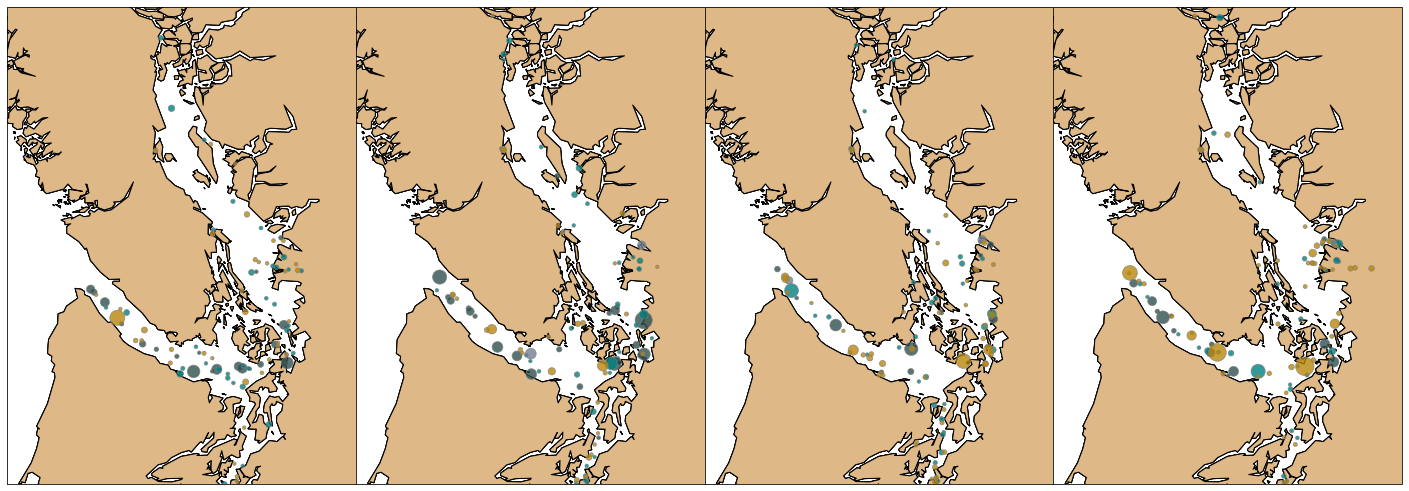

In [36]:
# define axis limits
axlim = np.zeros(4)
axlim[0] = -124.4
axlim[1] = -123.8
axlim[2] = spill_locs.spill_lat.min()
axlim[3] = spill_locs.spill_lat.max()

ms = 400

rotated_crs = cartopy.crs.RotatedPole(pole_longitude=120.0, pole_latitude=63.75)
plain_crs = cartopy.crs.PlateCarree()
from cartopy.io import shapereader as shpreader 
%matplotlib inline   
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(25, 20),
                       gridspec_kw={
                           'width_ratios': [1, 1,1,1],
                           'height_ratios': [1],
                       'wspace': 0,
                       'hspace': 0},
                       subplot_kw={"projection": rotated_crs, "facecolor": "white"})
for plot_index,file_index in enumerate([3,4,7,1]):
    file = filenames[file_index]    
    fig.subplots_adjust(hspace=0.1)
    terminal_loc = 0
    for idx,oil_type in enumerate([*spill_locs_byoil[file_index]]):
        spill_volume_fraction[file_index] = spill_locs_byoil[file_index][oil_type].spill_volume/max_spill_volume
        axs[plot_index].add_feature(feature.GSHHSFeature(
            'auto', 
            edgecolor='black', 
            facecolor='burlywood',
            alpha=1
        ), zorder=1)
        scatter_oil = axs[plot_index].scatter(spill_locs_byoil[file_index][oil_type].spill_lon, 
               spill_locs_byoil[file_index][oil_type].spill_lat, 
               s = ms * spill_volume_fraction[file_index],
               label = oil_type,
               color=oil.MIDOSScolors[oil_type],
               alpha = 0.8,
               edgecolors='grey',
               linewidth=0.7,
               transform=plain_crs,
               zorder=2)
    #     handles, labels = scatter_oil.legend_elements(prop="sizes", color=oil_colors[1], num=3, alpha=1)
    #     legend = axs[plot_index].legend(handles, labels, loc="upper right", title="volume (liters)")
    #     plt.setp(legend.get_title(),fontsize='xx-large')
        #axs.set_title(oil_type)
        axs[plot_index].set_extent(axlim, crs=plain_crs)
    axs[plot_index].legend
    # axs[plot_index].text(-0.05,0.5,'100 largest spills in ' + filenames[file_index][-6:],
    #     rotation = 90,
    #     horizontalalignment='center',
    #     verticalalignment='center',
    #     transform = axs[plot_index].transAxes,
    #     fontsize = 14)
    fig.canvas.draw()

    print(plot_index)
    index += 1
plt.savefig(graphics_directory/'Figure_10_MEOPAR_ASM_2022.png')
plt.show()
